In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


<a name='Importing-1'></a>

### Importing All Nedded Packages

In [ ]:
!pip install medpy
!pip install pydicom
!pip install -U scikit-image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.8/151.8 KB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 15.9 MB/s eta 0:00:00
  Created wheel for medpy: filename=MedPy-0.4.0-py3-none-any.whl size=214964 sha256=1f660127496595ca932c57a708e8138ba0b99de1d9dae8c141bfaf70ea203c76
  Stored in directory: /root/.cache/pip/wheels/41/46/a2/7c585b78f216a3dd8723dbab5f439822fa5dfbff563757a49e
Successfully built medpy
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 25.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 77.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 MB 

In [ ]:
import os
import cv2
import time
import random
import pydicom
import numpy as np
from typing import Tuple
import matplotlib.pyplot as plt
from skimage.filters import threshold_yen, threshold_otsu
from skimage.measure import label, regionprops
from medpy.filter.smoothing import anisotropic_diffusion

<a name='Utilities-1'></a>

## Import random image from the extracted png image

In [ ]:
path = "/content/drive/MyDrive/GSOC/Dataset/Glioblastoma/UPENN-GBM/UPENN-GBM-00002/11-13-2001-NA-BRAINROUTINE-05064/11.000000-ep2dperf 3cc pre 12bolus-82091"

In [ ]:
filenames = os.listdir(path)
filenames = [f for f in filenames if f.endswith('.dcm')]

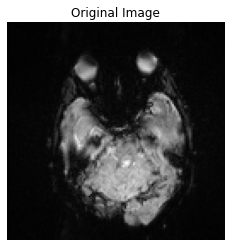

In [ ]:
pixel_array = cv2.imread('/content/0e0945dc4c1baad1df06f858f5282aa25776e15509c6ba26c5d952a2.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(pixel_array, cmap="gray")
plt.axis("off")
plt.title("Original Image")
plt.show()

## Try all threshold algorithms to choose the perfect one

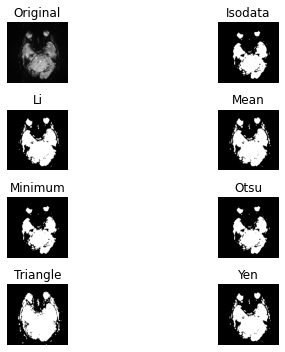

In [ ]:
from skimage.filters import try_all_threshold# Obtain all the resulting images
fig, ax = try_all_threshold(pixel_array, verbose=False)
# Showing resulting 
plt.show(fig)

<a name='Utilities-1'></a>

## Utilities to simplify the code

In [ ]:
def apply_otsu_threshold(image: np.ndarray) -> np.ndarray:
    """
    Applies Yen thresholding to the input image and returns a binary image.

    Args:
        image: A NumPy array representing the input image.

    Returns:
        A binary NumPy array representing the thresholded image.
    """
    # Apply Yen threshold to the filtered image
    threshold_value = threshold_otsu(image)
    binary_image = image > threshold_value

    # Return the binary image
    return binary_image


In [ ]:
def apply_anisotropic_diffusion_filter(image: np.ndarray) -> np.ndarray:
    """
    Applies an anisotropic diffusion filter to the input image and returns the filtered image.

    Args:
        image: A NumPy array representing the input image.

    Returns:
        A NumPy array representing the filtered image.
    """
    # Apply anisotropic diffusion filter to the image
    filtered_image = anisotropic_diffusion(image, niter=5, kappa=50, gamma=0.1)

    # Return the filtered image
    return filtered_image


In [ ]:
def apply_labeling(binary_image: np.ndarray) -> np.ndarray:
    """
    Labels connected regions in a binary image and returns the labeled image.

    Args:
        binary_image: A binary NumPy array representing the input image.

    Returns:
        A NumPy array representing the labeled image.
    """
    # Label connected regions in the binary image
    labeled_image = label(binary_image)

    # Return the labeled image
    return labeled_image


<a name='Utilities-1'></a>

## Visualize the landmarks

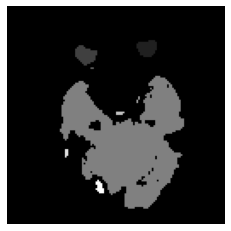

In [ ]:
# Apply anisotropic diffusion filter to the image
filtered_image = apply_anisotropic_diffusion_filter(pixel_array)

# Apply Yen threshold to the filtered image
binary_image = apply_otsu_threshold(filtered_image)

# Apply labeling to the binary image
labeled_image = apply_labeling(binary_image)
plt.imshow(labeled_image ,cmap = 'gray')
plt.axis("off")
plt.show()

<a name='Utilities-1'></a>

## Add the bounding box and the landmark detection

[<skimage.measure._regionprops.RegionProperties object at 0x7fa3776cab80>, <skimage.measure._regionprops.RegionProperties object at 0x7fa377406fa0>, <skimage.measure._regionprops.RegionProperties object at 0x7fa3776aa190>, <skimage.measure._regionprops.RegionProperties object at 0x7fa3771226a0>, <skimage.measure._regionprops.RegionProperties object at 0x7fa377122670>, <skimage.measure._regionprops.RegionProperties object at 0x7fa377122640>, <skimage.measure._regionprops.RegionProperties object at 0x7fa377122be0>, <skimage.measure._regionprops.RegionProperties object at 0x7fa377122c10>]


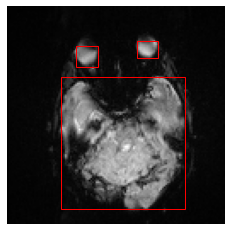

In [ ]:
from skimage import io, measure
regions = measure.regionprops(labeled_image)
print(regions)
# Create a figure and plot the original image
fig, ax = plt.subplots()
ax.imshow(pixel_array, cmap='gray')

# Loop over the regions and draw bounding boxes around them
for region in regions:
  
    # Get the coordinates of the bounding box
    bbox = region.bbox

    # Calculate the region area
    area = region.area

    # Ignore small regions
    if area < 50:
        continue

    # Draw the bounding box on the plot
    rect = plt.Rectangle((bbox[1], bbox[0]), bbox[3]-bbox[1], bbox[2]-bbox[0], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.axis("off")

# Show the plot
plt.show()

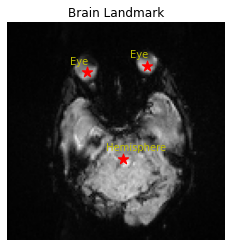

In [ ]:
# Create a figure and plot the original image
fig, ax = plt.subplots()
ax.imshow(pixel_array, cmap='gray')

# Loop over the regions and draw a star on the center of each bounding box if the region is large enough
for region in regions:
    # Get the coordinates of the bounding box
    bbox = region.bbox
    
    # Calculate the region area
    area = region.area

    # Ignore small regions
    if area < 50:
        continue
    
    # Get the center of the bounding box
    center = ((bbox[1] + bbox[3]) / 2, (bbox[0] + bbox[2]) / 2)
    
    # Draw a star on the center of the bounding box with a size based on the area of the region
    size = area / 100
    ax.scatter(center[0], center[1], marker='*', s=120, c='r')
    
    if area > 1000:
      # Add a label for the star based on the size of the region
      ax.text(center[0] -10, center[1] - 5 , 'Hemisphere', color='y', fontsize=10)
    elif bbox[1] > 20 :
        ax.text(center[0] -10, center[1] - 5 , 'Eye', color='y', fontsize=10)


# Set the axis labels and title
ax.set_xlabel('Column')
ax.set_ylabel('Row')
ax.set_title('Brain Landmark')
ax.axis("off")

# Show the plot
plt.show()